# EEMD + ARIMA

## Data Description

    - Raw data: Historical Product Demand.csv

    - Input data: Data on 8x augmentation of demand records by selecting 8 representative items

    - Product code: 'Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
                    'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004'
            

    - Size of Data: 116392 rows × 4 columns

    - Features: Date, Product_Code, Product_Category, Order_Demand

    - Period: 2012-01-01 ~ 2017-01-09
    

---

In [17]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date
from datetime import timedelta
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

# Save the log
import os
import pickle

import time
# EEMD
from PyEMD import EEMD

# ARIMA
from pmdarima.arima import auto_arima

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

## Data Explore

In [18]:
df = pd.read_csv('Data\\train.csv')
df = df[(df['store']==1)]

pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())
df = df.reset_index(drop=True)
df.rename(columns={'date': 'Date', 'item':'Product_Code', 'sales':'Order_Demand'}, inplace=True)
df = df[['Date', 'Product_Code', 'Order_Demand']]
df['Date'] = pd.to_datetime(df['Date'])
df['Product_Code'] = df['Product_Code'].astype('str')

In [19]:
print(df.info())
print('-------------------------')
print("")
print("The Number of unique")
print('-------------------------')
print('Product code:\t', df.Product_Code.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91300 entries, 0 to 91299
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          91300 non-null  datetime64[ns]
 1   Product_Code  91300 non-null  object        
 2   Order_Demand  91300 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.1+ MB
None
-------------------------

The Number of unique
-------------------------
Product code:	 50


---

## Data Split

- Input
     data: dataframe with dates and Demand data
     
- output
    - train:  2012-01-01 ~ 2015-12/31 
    - test :  2016-01-01 ~ 2017-01-06 

In [20]:
# train과 test로 데이터 split
def split_data(df):
    train_size = int(len(df) * 0.9)
    train_df = df[:train_size].copy()
    test_df = df[train_size:].copy()
    return train_df, test_df

---

## EEMD
    * 시계열 그래프를 ensembled IMF (앙상블 내재모드 함수)로 분해
    * n 개의 eIMFs와  1개의 Residual 생성

In [60]:
def eemd_fit(df):
    # Define signal
    t = np.array(df['Date']) # x-axis
    s = np.array(df['y']) # y-axis
    
    # EEMD 객체 생성
    eemd = EEMD() # trials: EMD 횟수(default:100)
    
#     # 극값을 감지하는 방법으로 parabolic 방법을 선택
#     emd = eemd.EMD
#     emd.extrema_detection="parabol"
    
    # eIMFs로 분해
    eIMFs = eemd.eemd(s, t, max_imf=4) # max_imf: IMF 제한 개수(-1: 없음)
    nIMFs = eIMFs.shape[0] # eIMF의 개수
    
    # 분해된 eIMFs와 잔차를 변수에 할당
    imfs, residue = eemd.get_imfs_and_residue()
    
    # 앙상블 IMFs 들의 DataFrame 생성
    all_eIMFs_df = pd.DataFrame(eIMFs).transpose() 
    all_eIMFs_df[nIMFs] = residue # residue 열 마지막 열로 추가
    all_eIMFs_df.insert(0, 'Date', df['Date']) # Date 열 추가
    
    # IMF & Residue 시각화
    plt.figure(figsize=(12, nIMFs*2)) # Figure size 설정
    for i in range(nIMFs):
        plt.subplot(nIMFs+1, 1, i+1) # i번째 subplot
        plt.plot(df['Date'], all_eIMFs_df[i], 'g')
        plt.title('IMF '+str(i+1), fontsize=10)

    # Residue plot
    plt.subplot(nIMFs+1, 1, nIMFs+1)
    plt.plot(df['Date'], all_eIMFs_df[nIMFs], 'r')
    plt.title('Residue', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return all_eIMFs_df, nIMFs # eIMF+Residue들로 이루어진 df, eIMF의 개수

### eIMFs 데이터프레임 추출

In [61]:
# eIMF들을 추출하여, Date와 y로 이루어진 데이터프레임 추출하고 딕셔너리에 저장
def extract_eIMFs(all_eIMFs_df, nIMFs):
    all_eIMFs_dict = {}
    # eIMF개수+Residue(1) 만큼 반복
    for i in range(nIMFs+1):
        tmp_df = all_eIMFs_df[['Date', i]] # n번째 eIMF에 해당하는 날짜와 값 추출
        tmp_df.columns=['Date', 'y'] # i -> y 로 열이름 변경
        all_eIMFs_dict[f'eIMFs_{i}'] = tmp_df # n번째 eIMF 정보(마지막은 Residue) 딕셔너리에 저장
        
                           # df: Date, y 2열로 이루어진 dataFrame
    return all_eIMFs_dict # {eIMFs_1: df1, eIMFs_2: df2, ...} 

### ARIMA combined EEMD 


In [72]:
'''
eIMFs의 DataFrame을 하나씩 반복하면서,
auto_arima로 (p,d,q)의 최적값을 찾고,
각 eIMFs들을 예측하고 예측 DataFrame을 Return
'''
def EEMD_ARIMA(all_eIMFs_dict):
    model_dict = {}
    pred_dict = {}
    
    for i in all_eIMFs_dict.keys():
        print(f'--------Total: 0~{len(all_eIMFs_dict)-1} eIMFs, Now: {i} --------')
        # eIMF_df 불러오기
        eIMF_df = all_eIMFs_dict[i]
        # Data split
        train_df, test_df = split_data(eIMF_df)
        # 저장할 값
        predictions = []
        # Search the propper (p,d,q)
        best_model = auto_arima(train_df['y'], 
                            start_p=1, start_q=1,
                            max_p=4, max_q=4, 
                            max_d=2, trace=True,
                            suppress_warnings=True)
        for test_date in test_df['Date']:
            # Use data up to the day before the test date to train the model
            train_until_test_df = eIMF_df[eIMF_df['Date'] < test_date]
 
            # fitting the model with best(p,d,q)
            best_model_fit = best_model.fit(train_until_test_df['y'])
        
            # Predict the next day's value and add it to the predictions list
            prediction = best_model_fit.predict(n_periods=1).reset_index(drop=True)[0]
        # Make the Result DataFrame
        res_df = test_df.copy()
        res_df['Pred'] = predictions
        
        # 'y'와 'Pred' 열을 정규화
        scaler = MinMaxScaler()
        res_df[['y_norm', 'Pred_norm']] = scaler.fit_transform(res_df[['y', 'Pred']])
        
        res_df.set_index('Date', inplace=True)
        # res_df: ['y'','Pred','y_norm','Pred_norm'] index='Date'
        # dictionary에 result_df 저장
        pred_dict[i] = res_df
        
    return model_dict, pred_dict

## Save and Load the model 

In [63]:
def save_model(product_code, model_dict):
    today = date.today()
    folder_path = 'Result/EEMD+ARIMA_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict, f)
    return model_dict

In [64]:
# 학습된 모델 pickle파일에서 불러오기
def load_model(file_name):
    file_path = f'Result/EEMD+ARIMA_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return model_dict

## Total Result

    - 각각의 eIMFs들의 예측값을 합하여 전체의 예측값을 도출하였음.
    - 전체 예측값이 음수가 나온 경우 0으로 대치함.
    - EEMD의 수식은 아래에 근거하였음.
    
        IMFs(t)=ΣIMFs j(t)
        
    
 

In [65]:
def make_all_result_df(pred_dict):
    all_df = pd.DataFrame()
    for tmp_df in pred_dict.values():
        all_df = pd.concat([all_df, tmp_df], axis=1)
    pred_df = all_df['Pred'].sum(axis=1) # eIMFs 예측값을 모두 더함
    actual_df = all_df['y'].sum(axis=1)
    # 전체 결과 데이터프레임 생성
    all_result_df = pd.DataFrame({'Pred': pred_df, 'y': actual_df})
    all_result_df.loc[all_result_df['Pred']<0, 'Pred']=0 # 음수 예측 값은 0으로 대치
    # MinMaxScaler를 이용하여 정규화
    # 날짜(Date) 열은 정규화하지 않으므로 제외
    result_norm = all_result_df[['Pred', 'y']]
    
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(result_norm)
    
    # 정규화된 데이터를 데이터 프레임에 반영합니다.
    all_result_df['Pred_norm'] = normalized_data[:,0]
    all_result_df['y_norm'] = normalized_data[:,1]
    # all_res_df: ['y'','Pred','y_norm','Pred_norm'] index='Date'
    return all_result_df

## Plot the result

In [66]:
"""
Plot the actual vs predition and save the figure in the given directory
"""
def actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, normalize=False):
    today = date.today()
    # 전체 결과 비교를 위해 dictionary에 추가
    pred_dict['all_result'] = all_result_df
    
    save_path = os.path.join("Result", "EEMD+ARIMA_Result", product_code+f'_{today.month:02d}{today.day:02d}')
    # Normalize된 결과는 다른 path에 저장
    if normalize: save_path += "_normalized"
    # 결과 df 하나씩 불러오기
    for i, pred_df in enumerate(pred_dict.values()):
        img_n = len(pred_dict)
        title = f"Pred Actual Plot - ({i+1}/{len(pred_dict)-1})'s eIMF"
        actual = pred_df['y']
        pred = pred_df['Pred']
        save_name = f'{product_code}_eIMF_{i+1}'
        # All result -> 마지막 image
        if i == img_n-1: 
            title = f"{product_code}-All Result"
            save_name = f'{product_code}_all_result'
        # 정규화 된 경우 actual, pred 값 달라짐
        if normalize:
            title += "(Normalized)"
            actual = pred_df['y_norm']
            pred = pred_df['Pred_norm']
            
        plt.figure(figsize=(16, 8))
        plt.title(title, fontsize=20)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Order Demand", fontsize=14)
        plt.plot(actual, label ='Actual', alpha=0.6)
        plt.plot(pred, label='Prediction', alpha=0.8)
        plt.legend(loc="upper right")
        
        # Plot 결과 저장
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save the figure
        today_date = f'_{today.month:02d}{today.day:02d}'
        plt.savefig(os.path.join(save_path, save_name+'.png'))
    # metric도 각 path에 
    metric_df.to_csv(os.path.join(save_path, f'{product_code}_Metric.csv'))
    del pred_dict['all_result']
        
    plt.close('all') # close all figures to free up memory

## Metrics

In [67]:
# Model Metric
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n-1)
    
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [68]:
def calculate_metrics(pred_df, normalize):
    # 계산된 메트릭을 저장하기 위해 데이터프레임 초기화
    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])

    # 정규화 옵션이 True인 경우 정규화된 데이터 사용, 
    # 그렇지 않으면 원래 데이터 사용
    if normalize:
        actual = pred_df['y_norm']
        pred = pred_df['Pred_norm']
    else:
        actual = pred_df['y']
        pred = pred_df['Pred']

    # 메트릭 계산
    # MASE = mase(np.array(train_series), np.array(actual), pred) 
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)
    # RMSLE = mean_squared_log_error(actual, pred)**0.5 

    # 계산된 메트릭을 데이터프레임에 추가
    tmp_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]})

    # 메트릭 데이터프레임에 결과 추가
    metric_df = pd.concat([metric_df, tmp_df])
    return metric_df

---

## Check the Result

In [69]:
def make_metric_df(product_code, pred_dict, all_result_df, normalize):
    today = date.today()

    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    # eIMF 반복하면서 Metric 평가
    for i, pred_df in pred_dict.items():
        imf_df = calculate_metrics(pred_df, normalize=normalize)
        metric_df = pd.concat([metric_df, imf_df])
    
    imf_idx = pd.Index(['eIMF_'+str(i+1) for i in range(len(pred_dict))]) # changed result_dict to pred_dict
    metric_df.index = imf_idx # Assign the created index to metric_df
    metric_df = pd.concat([metric_df, calculate_metrics(all_result_df, normalize=normalize)], axis=0)
    metric_df = metric_df.rename(index={metric_df.index[-1]: 'All'}) # 마지막 행은 Total 결과
    
    return metric_df

In [70]:
def execute_EEMD_ARIMA(product_code):
    start_time = time.time()

    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product_Code']== product_code].reset_index(drop=True)
    product_df.rename(columns={'Order_Demand': 'y'}, inplace=True)
    # EEMD 수행
    all_eIMFs_df, nIMFs = eemd_fit(product_df)
    # EEMD 결과에서 각 eIMFs' DF 추출
    all_eIMFs_dict = extract_eIMFs(all_eIMFs_df, nIMFs)
    
    # EEMD+ARIMA 실행
    model_dict, pred_dict = EEMD_ARIMA(all_eIMFs_dict) #dictionary, time_steps, epochs
    all_result_df = make_all_result_df(pred_dict)
    # 모델 저장
    save_model(product_code, model_dict)
    metric_df_norm = make_metric_df(product_code, pred_dict, all_result_df, True)
    metric_df = make_metric_df(product_code, pred_dict, all_result_df, False)
    
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df_norm, True)
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, False)
    
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력
    - ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
       'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']

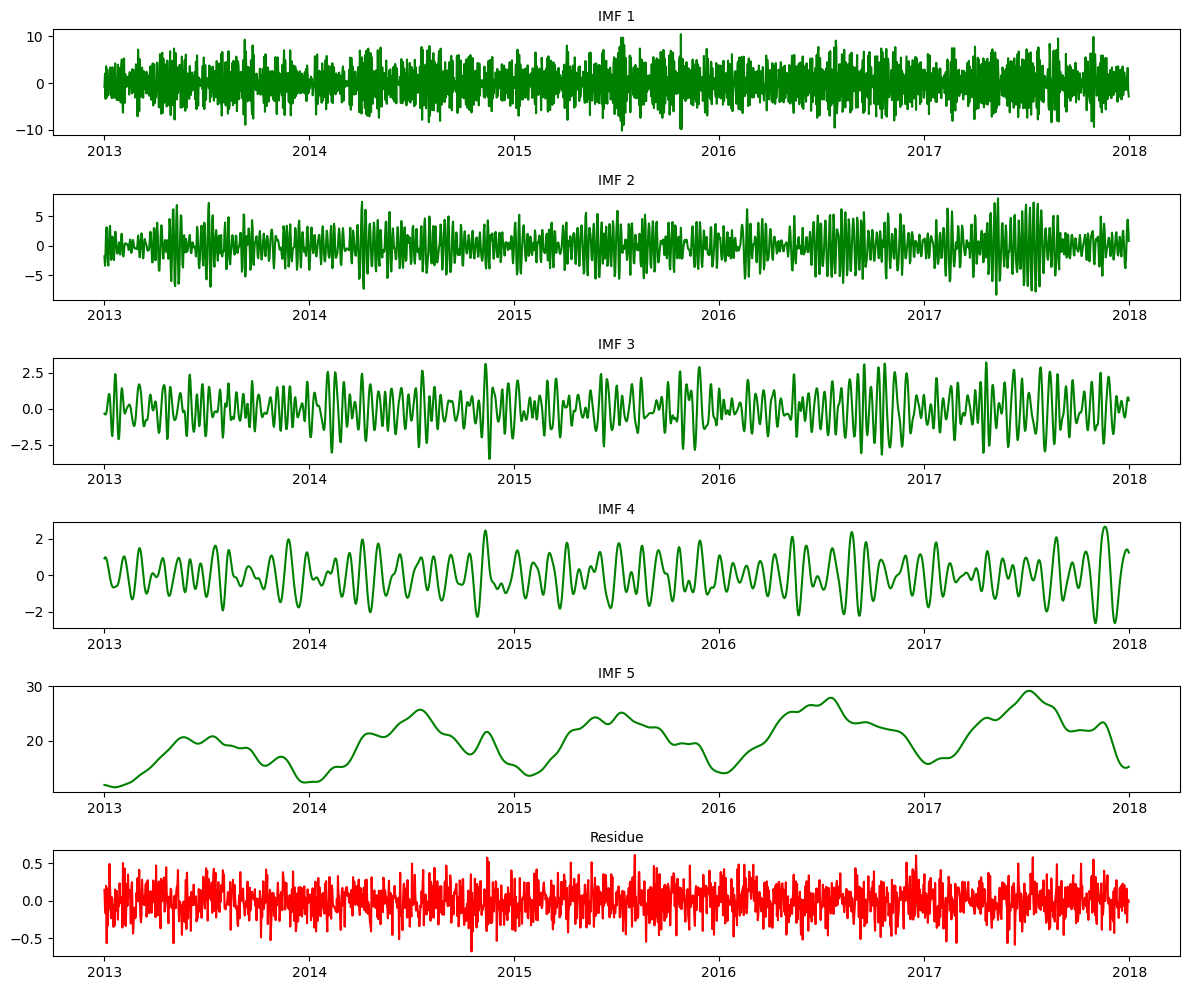

--------Total: 0~5 eIMFs, Now: eIMFs_0 --------
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8311.713, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9050.932, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8593.850, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8322.948, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9049.079, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8292.440, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8363.430, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8291.181, Time=0.61 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8294.512, Time=0.30 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8292.277, Time=0.97 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8293.122, Time=1.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8292.983, Time=0.58 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8290.963, Time=0.38 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8290.511,

,MAPE,RMSE,MAE,NRMSE,NMAE,R2
eIMF_1,3.1389,3.8032,2.9953,-59.8019,-47.0984,0.0666
eIMF_2,3.9000,2.0505,1.3380,112.3089,73.2823,0.4608
eIMF_3,4.0292,0.9181,0.5644,-117.3181,-72.1245,0.5148
eIMF_4,2.5567,0.9431,0.6092,18.4866,11.9416,0.4850
eIMF_5,0.0045,0.1392,0.1023,0.0061,0.0045,0.9987
eIMF_6,0.1634,0.1953,0.1545,31.1960,24.6847,-0.0010
All,0.2066,5.1941,4.1352,0.2270,0.1807,0.3901


In [71]:
execute_EEMD_ARIMA('4')

In [6]:
for code in ['Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']:
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    execute_EEMD_ARIMA(code)

========== Product_1248 ==========


NameError: name 'time' is not defined

## Load the model
    - 추후, 모델 결과를 다시 확인 할 일 있을 때, Model 파일 안에 있는 pickle 파일 로드

In [180]:
load_model('Product_0739_0503.pkl')

{'eIMFs_0': ARIMA(order=(0, 0, 2), scoring_args={}, seasonal_order=(2, 0, 0, 3),
       suppress_warnings=True),
 'eIMFs_1': ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(2, 0, 0, 3),
       suppress_warnings=True),
 'eIMFs_2': ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(2, 0, 1, 3),
       suppress_warnings=True),
 'eIMFs_3': ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(2, 0, 1, 3),
       suppress_warnings=True, with_intercept=False),
 'eIMFs_4': ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 3),
       suppress_warnings=True),
 'eIMFs_5': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 3),
       suppress_warnings=True, with_intercept=False),
 'eIMFs_6': ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(2, 0, 1, 3),
       suppress_warnings=True, with_intercept=False),
 'eIMFs_7': ARIMA(order=(1, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 3),
       suppress_warnings=True, with_intercept=False),
 'eIMFs_